In [12]:
#
# In this notebooks we make maps of data
#
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from src.plotting import *
from src.regions import *
from src.pf_stats import *
from src.daily import *
from src.cmorph import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
pf_stats = load_global_pf_stats()

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_60298/2526280273.py:64: RuntimeWarning: invalid value encountered in divide
  stat = N_exps / N_all * 100


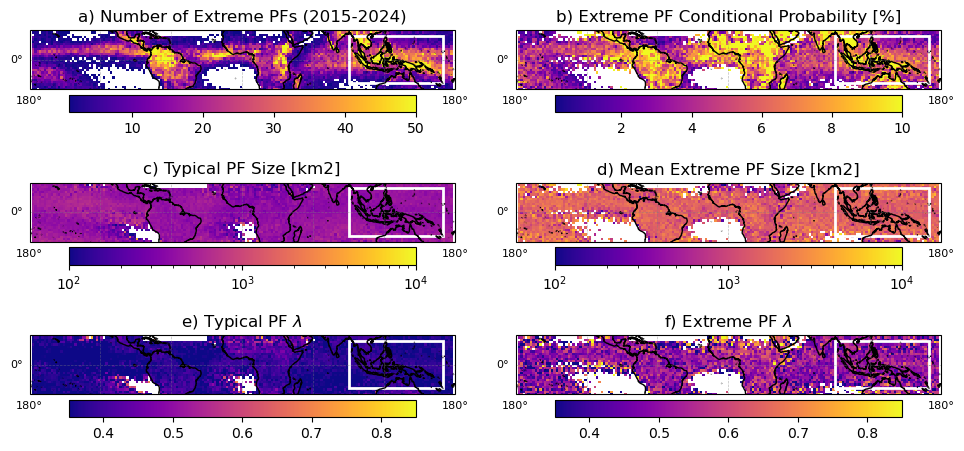

In [18]:
fig, axs = plt.subplots(
    figsize=(10, 5),
    nrows=3, 
    ncols=2,
    subplot_kw={'projection': ccrs.PlateCarree()}
)

ExPS_THRESH = 60
CORE_THRESH = 10
TyPS_MIN = pf_stats['max_precip'].quantile(0.25)
TyPS_MAX = pf_stats['max_precip'].quantile(0.75)
lat_bins = np.arange(-60, 60, 2)
lon_bins = np.arange(-180, 180, 2)

lon_mesh, lat_mesh = np.meshgrid(lon_bins, lat_bins)

for ai, ax in enumerate(axs.ravel()):
    #
    # Different axes show different data
    #
    exps_id = (pf_stats['max_precip'] >= ExPS_THRESH)
    exps_stats = pf_stats[exps_id]

    typs_id = (
        (pf_stats['max_precip'] >= 0) &
        (pf_stats['max_precip'] >= TyPS_MIN) &
        (pf_stats['max_precip'] <= TyPS_MAX)
    )
    typs_stats = pf_stats[typs_id]

    match ai:

        # Number of ExPSs
        case 0:
            N_exps = binned_statistic_2d(
                exps_stats['mean_latitude'], 
                exps_stats['mean_longitude'], 
                None,
                bins=[lat_bins, lon_bins],
                statistic='count'
            ).statistic
            stat = N_exps
            cmap = plt.cm.plasma.copy()
            cmap.set_under('white')
            norm = colors.Normalize(vmin=1, vmax=50)
            title = 'Number of Extreme PFs (2015-2024)'

        # Fraction of ExPSs to All
        case 1:
            N_exps = binned_statistic_2d(
                exps_stats['mean_latitude'], 
                exps_stats['mean_longitude'], 
                None,
                bins=[lat_bins, lon_bins],
                statistic='count'
            ).statistic
            N_all = binned_statistic_2d(
                pf_stats['mean_latitude'], 
                pf_stats['mean_longitude'], 
                None,
                bins=[lat_bins, lon_bins],
                statistic='count'
            ).statistic
            stat = N_exps / N_all * 100
            cmap = plt.cm.plasma.copy()
            cmap.set_under('white')
            norm = colors.Normalize(vmin=1e-1, vmax=10)
            title = 'Extreme PF Conditional Probability [%]'

        # Mean Size of Typical PFs
        case 2:
            size_typs = binned_statistic_2d(
                typs_stats['mean_latitude'], 
                typs_stats['mean_longitude'], 
                typs_stats['num_pixels'] * 25,
                bins=[lat_bins, lon_bins],
                statistic=lambda x: np.nanmean(x)
            ).statistic
            stat = size_typs
            cmap = plt.cm.plasma.copy()
            norm = colors.LogNorm(vmin=1e2, vmax=1e4)
            title = 'Typical PF Size [km2]'

        # Mean Size of Extreme PFs
        case 3:
            size_exps = binned_statistic_2d(
                exps_stats['mean_latitude'], 
                exps_stats['mean_longitude'], 
                exps_stats['num_pixels'] * 25,
                bins=[lat_bins, lon_bins],
                statistic=lambda x: np.nanmean(x)
            ).statistic
            stat = size_exps
            cmap = plt.cm.plasma.copy()
            norm = colors.LogNorm(vmin=1e2, vmax=1e4)
            title = 'Mean Extreme PF Size [km2]'

        # Typical PF localization
        case 4:
            loc_typs = binned_statistic_2d(
                typs_stats['mean_latitude'], 
                typs_stats['mean_longitude'], 
                typs_stats[f'largest_{CORE_THRESH:0d}mmhr_cluster_precip_4conn'] / typs_stats['total_precip'],
                bins=[lat_bins, lon_bins],
                statistic=lambda x: np.nanmean(x)
            ).statistic
            stat = loc_typs
            cmap = plt.cm.plasma.copy()
            norm = colors.Normalize(vmin=0.35, vmax=0.85)
            title = r'Typical PF $\lambda$'

        # Extreme PF localization
        case 5:
            loc_exps = binned_statistic_2d(
                exps_stats['mean_latitude'], 
                exps_stats['mean_longitude'], 
                exps_stats[f'largest_{CORE_THRESH:0d}mmhr_cluster_precip_4conn'] / exps_stats['total_precip'],
                bins=[lat_bins, lon_bins],
                statistic=lambda x: np.nanmean(x)
            ).statistic
            stat = loc_exps
            cmap = plt.cm.plasma.copy()
            norm = colors.Normalize(vmin=0.35, vmax=0.85)
            title = r'Extreme PF $\lambda$'

    #
    # Plot the data
    #
    c = ax.pcolormesh(
        lon_mesh, 
        lat_mesh, 
        stat, 
        cmap=cmap, 
        norm=norm,
        transform=ccrs.PlateCarree()
    )
    ax.set_title(f"{chr(ord('a') + ai)}) {title}")
    ax.coastlines()

    # Set map extent
    ax.set_extent([-180, 180, -25, 25], crs=ccrs.PlateCarree())

    # Add colorbar for each subplot
    cb = fig.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)

    # -------------------------------------------------
    # ADD RED BOX: from 90°E to 170°E, and -20° to 20°
    # -------------------------------------------------
    rect = mpatches.Rectangle(
        (90, -20),       # (lon_min, lat_min)
        170 - 90,        # width in degrees
        20 - (-20),      # height in degrees
        linewidth=2,
        edgecolor='white',
        facecolor='none',
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)

    # Add lat/lon gridlines with labels
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), 
        draw_labels=True,
        linewidth=0.5, 
        color='gray', 
        alpha=0.5, 
        linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
    gl.ylocator = mticker.FixedLocator(np.arange(-60, 61, 30))
    gl.xlabel_style = {'size': 8, 'color': 'black'}
    gl.ylabel_style = {'size': 8, 'color': 'black'}

fig.tight_layout(pad=2.0)
save_figure(fig, 'Maps of Extreme and Typical PFs')